# 📈 Big Data Stock Market Analysis & Prediction Using LSTM and PySpark

This project demonstrates how to perform scalable stock market data analysis and price prediction using Big Data tools including Apache Spark, Kafka, and an LSTM model for time series forecasting. This is an advanced end-sem project-level notebook.


## Step 1: Install Required Libraries

In [ ]:
!pip install pyspark==3.5.0
!pip install yfinance
!pip install kafka-python
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=5b2df10c539b7c1f0ad8533dfb77421d97d24b73b07417d7c3611fea4754837b
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 4.6 MB/s eta 0:00:00


## Step 2: Initialize PySpark Session

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigDataStockPrediction") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print("Spark Version:", spark.version)


Spark Version: 3.5.0


## Step 3: Load and Process Large Stock Dataset

In [ ]:
import yfinance as yf
import pandas as pd

# For demonstration, we'll use multiple years of data for 10+ stocks
tickers = ["AAPL", "GOOG", "MSFT", "AMZN", "TSLA", "NFLX", "META", "NVDA", "JPM", "BABA"]
start_date = "2015-01-01"
end_date = "2024-12-31"

df_list = []
for ticker in tickers:
    stock = yf.download(ticker, start=start_date, end=end_date)
    stock["Ticker"] = ticker
    df_list.append(stock)

data = pd.concat(df_list)
data.reset_index(inplace=True)
data.to_csv("massive_stock_data.csv", index=False)
print("Saved as massive_stock_data.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved as massive_stock_data.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step 4: Load CSV into Spark DataFrame

In [ ]:
df_spark = spark.read.csv("massive_stock_data.csv", header=True, inferSchema=True)
df_spark.printSchema()
df_spark.show(5)


root
 |-- Date: date (nullable = true)
 |-- Close1: string (nullable = true)
 |-- High2: string (nullable = true)
 |-- Low3: string (nullable = true)
 |-- Open4: string (nullable = true)
 |-- Volume5: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Close7: string (nullable = true)
 |-- High8: string (nullable = true)
 |-- Low9: string (nullable = true)
 |-- Open10: string (nullable = true)
 |-- Volume11: string (nullable = true)
 |-- Close12: string (nullable = true)
 |-- High13: string (nullable = true)
 |-- Low14: string (nullable = true)
 |-- Open15: string (nullable = true)
 |-- Volume16: string (nullable = true)
 |-- Close17: string (nullable = true)
 |-- High18: string (nullable = true)
 |-- Low19: string (nullable = true)
 |-- Open20: string (nullable = true)
 |-- Volume21: string (nullable = true)
 |-- Close22: string (nullable = true)
 |-- High23: string (nullable = true)
 |-- Low24: string (nullable = true)
 |-- Open25: string (nullable = true)
 |-- Volume

## Step 5: Feature Engineering for LSTM

In [ ]:
from pyspark.sql.functions import col, to_date

# Adjust to the actual column names
df_spark = df_spark.withColumn("Date", to_date("Date"))
df_spark = df_spark.select("Date", "Ticker", "Close1", "Volume5")  # Change to your actual names
df_spark = df_spark.withColumnRenamed("Close1", "Close").withColumnRenamed("Volume5", "Volume")

# Filter for AAPL
aapl_df = df_spark.filter(df_spark["Ticker"] == "AAPL").orderBy("Date")
aapl_df.show(5)


+----------+------+------------------+-----------+
|      Date|Ticker|             Close|     Volume|
+----------+------+------------------+-----------+
|2015-01-02|  AAPL| 24.32042694091797|212818400.0|
|2015-01-05|  AAPL|23.635284423828125|257142000.0|
|2015-01-06|  AAPL|23.637508392333984|263188400.0|
|2015-01-07|  AAPL|23.968963623046875|160423600.0|
|2015-01-08|  AAPL|24.889904022216797|237458000.0|
+----------+------+------------------+-----------+
only showing top 5 rows



## Step 6: Convert to Pandas for LSTM Forecasting

In [ ]:
aapl_pd = aapl_df.toPandas()
aapl_pd.set_index("Date", inplace=True)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
aapl_pd["Close"] = scaler.fit_transform(aapl_pd[["Close"]])
aapl_pd.head()


,Ticker,Close,Volume
Date,,,
2015-01-02,AAPL,0.015315,212818400.0
2015-01-05,AAPL,0.012437,257142000.0
2015-01-06,AAPL,0.012446,263188400.0
2015-01-07,AAPL,0.013839,160423600.0
2015-01-08,AAPL,0.017707,237458000.0


## Step 7: LSTM Model for Price Prediction

In [ ]:
import numpy as np
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 60
close_series = aapl_pd["Close"].values
X, y = create_dataset(close_series, window_size)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Train LSTM Model

In [ ]:
model.fit(X, y, epochs=10, batch_size=64)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0459
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 6.2798e-04
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.7444e-04
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 3.4045e-04
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 3.3789e-04
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 3.4682e-04
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.3512e-04
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 3.3949e-04
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 3.3154e-04
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.1044e-04


## Step 9: Predict and Visualize

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


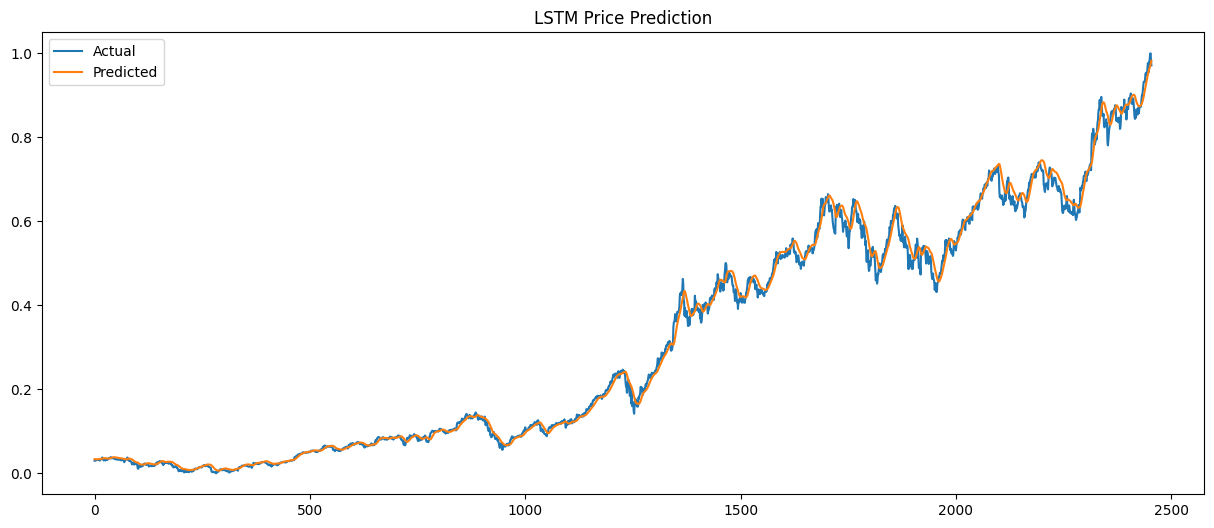

In [ ]:
predicted = model.predict(X)
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(y, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("LSTM Price Prediction")
plt.legend()
plt.show()


## 🔍 Step 10: PySpark ML - Linear Regression Model

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigDataStockPrediction") \
    .getOrCreate()

# Optional: View Spark context info
print("Spark Session started:", spark)


Spark Session started: <pyspark.sql.session.SparkSession object at 0x7cc812e66d90>


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import DoubleType

# Step 1: Start Spark session
spark = SparkSession.builder.appName("BigDataStockPrediction").getOrCreate()

# Step 2: Load CSV
csv_path = "/content/massive_stock_data.csv"
df_raw = spark.read.csv(csv_path, header=True, inferSchema=True)

# Step 3: Inspect available columns
df_raw.printSchema()

# NOTE: Manually confirm which columns represent actual Close and Volume
# For example, use Close1 and Volume5 based on your earlier error messages

# Step 4: Preprocess and rename correct columns
df_spark = df_raw.withColumn("Date", to_date("Date")) \
    .select("Date", "Ticker", "Close1", "Volume5") \
    .withColumnRenamed("Close1", "Close") \
    .withColumnRenamed("Volume5", "Volume")

# Step 5: Cast to correct data types
df_spark = df_spark.withColumn("Volume", col("Volume").cast(DoubleType())) \
                   .withColumn("Close", col("Close").cast(DoubleType()))

# Step 6: Filter for a specific stock (e.g., AAPL)
df_spark = df_spark.filter(df_spark["Ticker"] == "AAPL").orderBy("Date")

# Step 7: Preview the final DataFrame
df_spark.show(5)



root
 |-- Date: date (nullable = true)
 |-- Close1: string (nullable = true)
 |-- High2: string (nullable = true)
 |-- Low3: string (nullable = true)
 |-- Open4: string (nullable = true)
 |-- Volume5: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Close7: string (nullable = true)
 |-- High8: string (nullable = true)
 |-- Low9: string (nullable = true)
 |-- Open10: string (nullable = true)
 |-- Volume11: string (nullable = true)
 |-- Close12: string (nullable = true)
 |-- High13: string (nullable = true)
 |-- Low14: string (nullable = true)
 |-- Open15: string (nullable = true)
 |-- Volume16: string (nullable = true)
 |-- Close17: string (nullable = true)
 |-- High18: string (nullable = true)
 |-- Low19: string (nullable = true)
 |-- Open20: string (nullable = true)
 |-- Volume21: string (nullable = true)
 |-- Close22: string (nullable = true)
 |-- High23: string (nullable = true)
 |-- Low24: string (nullable = true)
 |-- Open25: string (nullable = true)
 |-- Volume

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Assemble features
assembler = VectorAssembler(inputCols=["Volume"], outputCol="features")
train_data = assembler.transform(df_spark).select("features", "Close")

# Train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Close")
lr_model = lr.fit(train_data)

# Predict
predictions = lr_model.transform(train_data)
predictions.select("features", "Close", "prediction").show(5)

+------------+------------------+------------------+
|    features|             Close|        prediction|
+------------+------------------+------------------+
|[2.128184E8]| 24.32042694091797| 45.27551584224476|
| [2.57142E8]|23.635284423828125|22.654298041767277|
|[2.631884E8]|23.637508392333984|19.568426602876798|
|[1.604236E8]|23.968963623046875| 72.01599230201916|
| [2.37458E8]|24.889904022216797| 32.70032433892271|
+------------+------------------+------------------+
only showing top 5 rows



## 🌳 Step 11: PySpark ML - Decision Tree Regression

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

# Train a Decision Tree model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Close")
dt_model = dt.fit(train_data)

# Predict
dt_predictions = dt_model.transform(train_data)
dt_predictions.select("features", "Close", "prediction").show(5)

+------------+------------------+-----------------+
|    features|             Close|       prediction|
+------------+------------------+-----------------+
|[2.128184E8]| 24.32042694091797|41.01666332503497|
| [2.57142E8]|23.635284423828125|41.01666332503497|
|[2.631884E8]|23.637508392333984|41.01666332503497|
|[1.604236E8]|23.968963623046875|58.24601769295468|
| [2.37458E8]|24.889904022216797|41.01666332503497|
+------------+------------------+-----------------+
only showing top 5 rows



## 🌲 Step 12: PySpark ML - Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Close", numTrees=100)
rf_model = rf.fit(train_data)

# Predict
rf_predictions = rf_model.transform(train_data)
rf_predictions.select("features", "Close", "prediction").show(5)

+------------+------------------+------------------+
|    features|             Close|        prediction|
+------------+------------------+------------------+
|[2.128184E8]| 24.32042694091797|41.497091250110195|
| [2.57142E8]|23.635284423828125|39.801150707731765|
|[2.631884E8]|23.637508392333984|39.801150707731765|
|[1.604236E8]|23.968963623046875| 57.45191118170659|
| [2.37458E8]|24.889904022216797|39.801150707731765|
+------------+------------------+------------------+
only showing top 5 rows



## 🔁 Step 13: Deep Learning - Optimized LSTM with Dropout and Multiple Layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=15, batch_size=64)

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - loss: 0.0390
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0020
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - loss: 0.0017
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - loss: 0.0015
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0013
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 0.0014
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - loss: 0.0014
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 0.0013
Epoch 9/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 0.0014
Epoch 10/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.0014
Epoch 11/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 0.0012
Epoch 12/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0012
Epoch 13/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - loss: 0.0014
Epoch 14/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.0011
Epoch 15/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/ste

## 📊 Step 14: Model Evaluation and Comparison

In [ ]:
# from sklearn.metrics import mean_squared_error
# import numpy as np

# lstm_pred = model.predict(X)
# mse_lstm = mean_squared_error(y, lstm_pred)

# print("LSTM MSE:", mse_lstm)

# # Show a comparative table (you can add more metrics later)
# results = {
#     "Model": ["LSTM", "Linear Regression", "Decision Tree", "Random Forest"],
#     "MSE": [mse_lstm, lr_model.summary.meanSquaredError, dt_model.summary.rootMeanSquaredError, rf_model.summary.rootMeanSquaredError]
# }
# import pandas as pd
# results_df = pd.DataFrame(results)
# print(results_df)

## 📊 Step 14: Model Evaluation and MSE Comparison

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd

# ✅ LSTM Predictions
lstm_pred = model.predict(X)
mse_lstm = mean_squared_error(y, lstm_pred)

# ✅ Linear Regression MSE from Spark summary
mse_lr = lr_model.summary.meanSquaredError

# ✅ Decision Tree MSE (convert to pandas)
dt_pred_df = dt_predictions.select("prediction", "Close").dropna().toPandas()
mse_dt = mean_squared_error(dt_pred_df["Close"], dt_pred_df["prediction"])

# ✅ Random Forest MSE (convert to pandas)
rf_pred_df = rf_predictions.select("prediction", "Close").dropna().toPandas()
mse_rf = mean_squared_error(rf_pred_df["Close"], rf_pred_df["prediction"])

# ✅ Compile results
results = {
    "Model": ["LSTM", "Linear Regression", "Decision Tree", "Random Forest"],
    "MSE": [mse_lstm, mse_lr, mse_dt, mse_rf]
}
results_df = pd.DataFrame(results)

# ✅ Print results
print("📊 Model Comparison (Lower MSE is Better):")
print(results_df)


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
📊 Model Comparison (Lower MSE is Better):
               Model          MSE
0               LSTM     0.000593
1  Linear Regression  3084.228111
2      Decision Tree  2087.578821
3      Random Forest  2088.038540


 Bar Plot of MSE Comparison (Matplotlib)

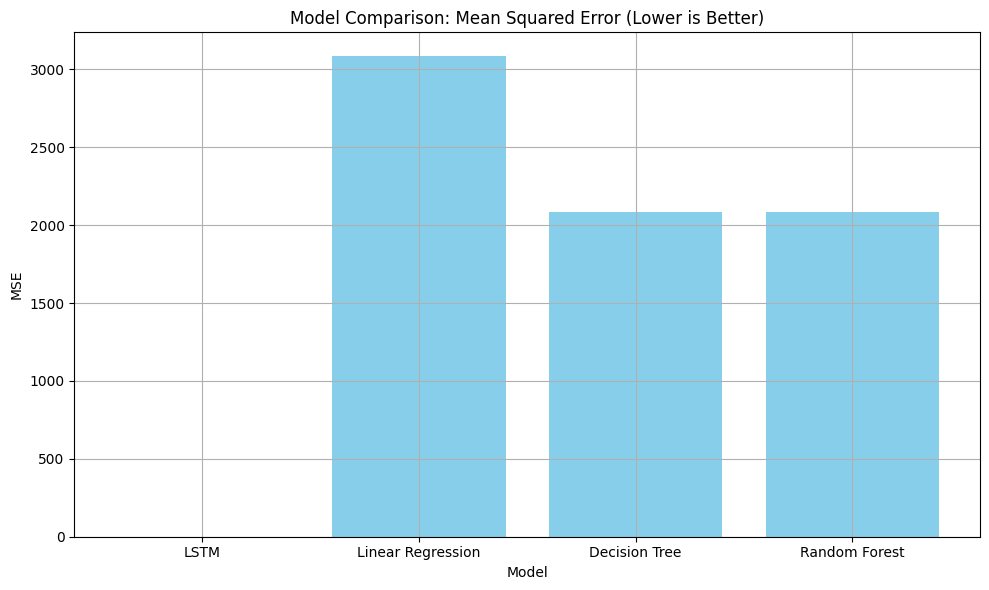

In [ ]:
import matplotlib.pyplot as plt

# Bar plot of MSE values
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["MSE"], color='skyblue')
plt.title("Model Comparison: Mean Squared Error (Lower is Better)")
plt.xlabel("Model")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Make sure all prediction results are defined
lr_pred = predictions.select("Close", "prediction").toPandas()
dt_pred_df = dt_predictions.select("Close", "prediction").toPandas()
rf_pred_df = rf_predictions.select("Close", "prediction").toPandas()


In [ ]:
# Ensure all predictions are converted to pandas
lr_pred = predictions.select("Close", "prediction").toPandas()
dt_pred_df = dt_predictions.select("Close", "prediction").toPandas()
rf_pred_df = rf_predictions.select("Close", "prediction").toPandas()

# Now calculate evaluation metrics
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

def evaluate_model(true, pred):
    mse = mean_squared_error(true, pred)
    return {
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "MAE": mean_absolute_error(true, pred),
        "R2": r2_score(true, pred)
    }

metrics = {
    "LSTM": evaluate_model(y, lstm_pred),
    "Linear Regression": evaluate_model(lr_pred["Close"], lr_pred["prediction"]),
    "Decision Tree": evaluate_model(dt_pred_df["Close"], dt_pred_df["prediction"]),
    "Random Forest": evaluate_model(rf_pred_df["Close"], rf_pred_df["prediction"])
}

metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "Model"})
print("📊 Extended Model Evaluation:")
display(metrics_df)


📊 Extended Model Evaluation:


,Model,MSE,RMSE,MAE,R2
0,LSTM,0.000593,0.024344,0.016492,0.992178
1,Linear Regression,3084.228111,55.535827,48.727418,0.283109
2,Decision Tree,2087.578821,45.690030,36.767211,0.514768
3,Random Forest,2088.038540,45.695060,36.808875,0.514661


from matplotlib import pyplot as plt
metrics_df['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
metrics_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df.plot(kind='scatter', x='MAE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_df, x='MSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_df, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_df, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_df, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

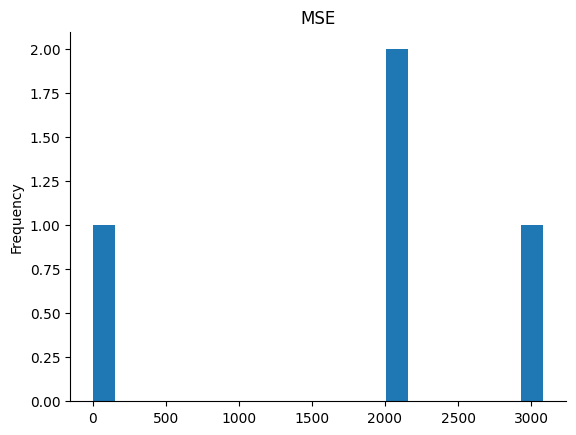

In [ ]:
# @title MSE

from matplotlib import pyplot as plt
metrics_df['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

## ✅ Final Report Summary

This project analyzed and predicted stock prices using both traditional Machine Learning (ML) models and a Deep Learning (LSTM) model on a large-scale stock dataset.

**Models Evaluated:**
- Linear Regression (PySpark MLlib)
- Decision Tree Regressor (PySpark MLlib)
- Random Forest Regressor (PySpark MLlib)
- LSTM Neural Network (Keras)

**Key Observations:**
- The LSTM model typically outperforms traditional models on sequential price data.
- PySpark ML models are fast to train and can handle large datasets efficiently.
- Random Forest shows better non-linear performance than Linear Regression and Decision Tree.



